# CS108/212 STAT108/212 W25 Course Project

### Team Details

- Teammate 1: Ruturaj Kanake
- Teammate 2: Shreyangshu Bera
- Teammate 3: Akshaya Samant
- Teammate 4: Muntaka Ibnath

---


# Milestone: Establishing Baselines
For this project milestone, each teammate will train a baseline model to assess pre-bias mitigation performance.

# Installs

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Imports

In [2]:
import kagglehub
pavansubhasht_ibm_hr_analytics_attrition_dataset_path = kagglehub.dataset_download('pavansubhasht/ibm-hr-analytics-attrition-dataset')

print('Data source import complete.')

100%|██████████| 50.1k/50.1k [00:00<00:00, 9.74MB/s]

Extracting files...
Data source import complete.


In [3]:
hr_data = pd.read_csv("/root/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1/WA_Fn-UseC_-HR-Employee-Attrition.csv")
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Loading dataset

In [4]:
# Load your selected dataset

y = hr_data['Attrition']
X = hr_data.drop(columns=['Attrition'])

# Print some stats
print(f"No. of samples: {X.shape[0]}")
print(f"No. of features: {X.shape[1]}")

No. of samples: 1470
No. of features: 34


# Preparing dataset

In [5]:
print(f"No. of samples BEFORE cleaning: {X.shape[0]}")
print(f"No. of features BEFORE encoding: {X.shape[1]}")

No. of samples BEFORE cleaning: 1470
No. of features BEFORE encoding: 34


In [6]:
# Some subset of following dataset preparation steps may be necessary depending on your dataset,
# 1. Drop unnecessary features
# 2. Handle missing data
# 3. Encode categorical features
# 4. Normalize numerical features
# 5. Encode target (if your task is classification)

# 1. Drop unnecessary features
# Removing features that are not useful for prediction
X = X.drop(columns=["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"])

In [7]:
# 2. Handle missing data
# Using mean imputation for numerical columns and most frequent for categorical columns
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

In [8]:
# 3. Encode categorical features
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [9]:
# 4. Normalize numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [10]:
# 5. Encode target variable
y = LabelEncoder().fit_transform(y)

# Note: X and y have been modified before the following lines of code!
print(f"No. of samples AFTER cleaning: {X.shape[0]}")
print(f"No. of features AFTER encoding: {X.shape[1]}")

No. of samples AFTER cleaning: 1470
No. of features AFTER encoding: 30


In [11]:
# Sample model training to check the demographic parity difference.

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_temp = LogisticRegression()
model_temp.fit(X_train_temp, y_train_temp)
y_pred_temp = model_temp.predict(X_test_temp)


privileged_groups = {
    'Gender': {'privileged': 1, 'unprivileged': 0},
    'OverTime': {'privileged': 1, 'unprivileged': 0},
    'MaritalStatus': {'privileged': 1, 'unprivileged': 0},
}

data = X_test_temp.copy()
data['Attrition'] = y_pred_temp

def calculate_demographic_parity_difference(data, group_column, privileged_value, unprivileged_value, target_column='Attrition'):
    p_unprivileged = data[data[group_column] == unprivileged_value][target_column].mean()
    p_privileged = data[data[group_column] == privileged_value][target_column].mean()

    return p_privileged - p_unprivileged

# Calculate Demographic Parity Difference for each attribute
demographic_parity_differences = {}
for attribute, groups in privileged_groups.items():
    if attribute in data.columns:
        difference = calculate_demographic_parity_difference(
            data,
            attribute,
            groups['privileged'],
            groups['unprivileged']
        )
        demographic_parity_differences[attribute] = difference

for attribute, difference in demographic_parity_differences.items():
    print(f"Demographic Parity Difference for {attribute}: {difference:.3f}")

Demographic Parity Difference for Gender: 0.012
Demographic Parity Difference for OverTime: 0.222
Demographic Parity Difference for MaritalStatus: 0.029


In [12]:
sensitive_feature_colname = "OverTime" # sensitive feature name

# Make sensitive features-based group labels
group_labels = X[sensitive_feature_colname]

print(f"Group Counts: {dict(collections.Counter(group_labels))}")

# Ensure group labels are updated if necessary
group_labels = X[sensitive_feature_colname]
assert X.shape[0] == y.shape[0] == group_labels.shape[0]

Group Counts: {1: 416, 0: 1054}


# Getting training and testing sets

Note: Train-test split is made **ONCE** to obtain the _training set_ and the _testing set_ and every teammate will use the training set to train their baseline model and test the trained model using the testing set. **NEVER** modify the testing set once it has been created.

In [13]:
X_train, X_test, \
  y_train, y_test, \
    group_labels_train, group_labels_test = train_test_split(X, y, group_labels, test_size=0.2, random_state=42, stratify=y)

print(f"No. of training samples: {X_train.shape[0]}")
print(f"No. of testing samples: {X_test.shape[0]}")

# Delete X, y and group_label variables to make sure they are not used later on.
del X
del y
del group_labels

No. of training samples: 1176
No. of testing samples: 294


# Setting up evaluation metrics
Note: The same evaluation function will be used by all teammates.

In [14]:
def demographic_parity(y_pred, g_labels):
    """
    Computes the demographic parity difference.
    """
    unique_groups = np.unique(g_labels)
    proportions = {group: np.mean(y_pred[g_labels == group]) for group in unique_groups}
    return max(proportions.values()) - min(proportions.values())

def equalized_odds(y_test, y_pred, g_labels):
    """
    Computes the equalized odds difference.
    """
    unique_groups = np.unique(g_labels)
    tpr_diff = []
    fpr_diff = []

    for group in unique_groups:
        mask = g_labels == group
        tpr = np.sum((y_pred[mask] == 1) & (y_test[mask] == 1)) / np.sum(y_test[mask] == 1)
        fpr = np.sum((y_pred[mask] == 1) & (y_test[mask] == 0)) / np.sum(y_test[mask] == 0)
        tpr_diff.append(tpr)
        fpr_diff.append(fpr)

    return round(max(tpr_diff) - min(tpr_diff), 3), round(max(fpr_diff) - min(fpr_diff), 2)

def evaluate_model(y_test, y_pred, g_labels):
    """
    Evaluate the performance of the trained model on the testing set.

    Parameters
    ----------
    y_test : array-like
        The true labels of the testing set.
    y_pred : array-like
        The predicted labels of the testing set.
    g_labels : array-like
        The group labels of the testing set.

    Returns
    -------
    results : dict
        A dictionary containing performance and fairness evaluation results.
    """
    results = {}

    # Task-specific performance metrics (overall)
    results["accuracy"] = round(accuracy_score(y_test, y_pred), 2)
    results["f1_score"] = round(f1_score(y_test, y_pred), 2)
    results["precision"] = round(precision_score(y_test, y_pred), 2)
    results["recall"] = round(recall_score(y_test, y_pred), 2)

    # Performance metrics per group
    unique_groups = np.unique(g_labels)
    results["group_metrics"] = {
        group: {
            "accuracy": round(accuracy_score(y_test[g_labels == group], y_pred[g_labels == group]), 2),
            "f1_score": round(f1_score(y_test[g_labels == group], y_pred[g_labels == group]), 2),
            "precision": round(precision_score(y_test[g_labels == group], y_pred[g_labels == group]), 2),
            "recall": round(recall_score(y_test[g_labels == group], y_pred[g_labels == group]), 2)
        }
        for group in unique_groups
    }

    # Fairness metrics
    results["demographic_parity"] = round(demographic_parity(y_pred, g_labels), 3)
    results["equalized_odds"] = equalized_odds(y_test, y_pred, g_labels)

    return results

# Training baseline models

In [15]:
all_baseline_results = []

## Teammate 1

In [16]:
model = DecisionTreeClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = evaluate_model(y_test, y_pred, group_labels_test)
for key, values in results.items():
  print(key, ":", values)
results['teammate'] = 'Teammate 1'
results['experiment_type'] = 'pre-mitigation'
results['predictor_model'] = 'Decision Tree'
results['mitigation_strategy'] = 'No Mitigation'
all_baseline_results.append(results)

accuracy : 0.8
f1_score : 0.33
precision : 0.36
recall : 0.3
group_metrics : {0: {'accuracy': 0.84, 'f1_score': 0.05, 'precision': 0.05, 'recall': 0.06}, 1: {'accuracy': 0.7, 'f1_score': 0.53, 'precision': 0.68, 'recall': 0.43}}
demographic_parity : 0.158
equalized_odds : (0.375, 0.04)


### Teammate 1's Conclusions

1. The decision tree model achieves reasonable overall accuracy at 80%, but shows concerning disparities between groups with Group 0 having higher accuracy (84%) yet extremely poor F1 score (0.05), while Group 1 has lower accuracy (70%) but substantially better predictive performance with an F1 score of 0.53.

2. The demographic parity value of 0.158 and unbalanced equalized odds values (0.375, 0.04) indicate serious fairness concerns as the model makes positive predictions at different rates between overtime and non-overtime groups and shows unequal error distributions.

3. With overall low precision (0.36) and recall (0.3), the model struggles with prediction quality, particularly showing a stark contrast in Group 1 where higher precision (0.68) compared to recall (0.43) suggests the model is overly conservative when making positive predictions for the overtime group.

## Teammate 2

In [17]:
model = RandomForestClassifier(max_depth=20, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = evaluate_model(y_test, y_pred, group_labels_test)
for key, values in results.items():
  print(key, ":", values)
results['teammate'] = 'Teammate 2'
results['experiment_type'] = 'pre-mitigation'
results['predictor_model'] = 'Random Forest'
results['mitigation_strategy'] = 'No Mitigation'
all_baseline_results.append(results)

accuracy : 0.84
f1_score : 0.2
precision : 0.46
recall : 0.13
group_metrics : {0: {'accuracy': 0.9, 'f1_score': 0.08, 'precision': 0.14, 'recall': 0.06}, 1: {'accuracy': 0.66, 'f1_score': 0.28, 'precision': 0.83, 'recall': 0.17}}
demographic_parity : 0.047
equalized_odds : (0.108, 0.01)


### Teammate 2's Conclusions

1. The Random Forest model demonstrates high overall accuracy of 84% but suffers from poor predictive performance with a low F1 score of 0.2, high precision of 0.46, and particularly low recall of 0.13 indicating it misses most positive cases.

2. There exists a substantial performance gap between groups with Group 0 showing excellent accuracy (90%) but minimal predictive capability (F1: 0.08), while Group 1 shows lower accuracy (66%) with better but still insufficient predictive metrics (F1: 0.28), though its precision is remarkably high at 0.83.

3. The fairness metrics show improvement compared to the Decision Tree with a lower demographic parity of 0.047 and more balanced equalized odds (0.108, 0.01), suggesting this model makes more consistent predictions across overtime groups despite its overall limited ability to identify positive cases.


## Teammate 3

In [18]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = evaluate_model(y_test, y_pred, group_labels_test)
for key, values in results.items():
  print(key, ":", values)
results['teammate'] = 'Teammate 3'
results['experiment_type'] = 'pre-mitigation'
results['predictor_model'] = 'Logistic Regression'
results['mitigation_strategy'] = 'No Mitigation'
all_baseline_results.append(results)

accuracy : 0.88
f1_score : 0.5
precision : 0.72
recall : 0.38
group_metrics : {0: {'accuracy': 0.93, 'f1_score': 0.35, 'precision': 0.67, 'recall': 0.24}, 1: {'accuracy': 0.72, 'f1_score': 0.57, 'precision': 0.74, 'recall': 0.47}}
demographic_parity : 0.222
equalized_odds : (0.231, 0.1)


### Teammate 3's Conclusions

1. The Logistic Regression model achieves the highest overall accuracy at 88% with significantly better predictive performance compared to previous models, showing a balanced F1 score of 0.5, strong precision of 0.72, but still limited recall at 0.38.

2. Group performance shows a similar pattern where Group 0 has excellent accuracy (93%) with moderate predictive metrics (F1: 0.35), while Group 1 has lower accuracy (72%) but better predictive capability (F1: 0.57), with both groups having similar precision but Group 1 demonstrating nearly double the recall rate.

3. The fairness metrics indicate increased disparity with demographic parity at 0.222 and equalized odds at (0.231, 0.1), suggesting that while this model performs better overall, it makes less consistent predictions across overtime groups than the Random Forest model.


## Teammate 4

In [19]:
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = evaluate_model(y_test, y_pred, group_labels_test)
for key, values in results.items():
  print(key, ":", values)
results['teammate'] = 'Teammate 4'
results['experiment_type'] = 'pre-mitigation'
results['predictor_model'] = 'SVM'
results['mitigation_strategy'] = 'No Mitigation'
all_baseline_results.append(results)

accuracy : 0.88
f1_score : 0.45
precision : 0.93
recall : 0.3
group_metrics : {0: {'accuracy': 0.94, 'f1_score': 0.36, 'precision': 0.8, 'recall': 0.24}, 1: {'accuracy': 0.74, 'f1_score': 0.5, 'precision': 1.0, 'recall': 0.33}}
demographic_parity : 0.109
equalized_odds : (0.098, 0.0)


### Teammate 4's Conclusions

1. The SVM model maintains the high overall accuracy of 88% seen in Logistic Regression but shows a slight decrease in F1 score to 0.45, though it achieves exceptional precision of 0.93 at the cost of lower recall at 0.3, indicating it makes fewer but more accurate positive predictions.

2. The group performance displays the familiar pattern with Group 0 showing very high accuracy (94%) but moderate predictive capability (F1: 0.36), while Group 1 has lower accuracy (74%) but better predictive metrics (F1: 0.5), with Group 1 achieving perfect precision of 1.0 meaning every positive prediction it makes is correct.

3. The fairness metrics show moderate improvement over Logistic Regression with demographic parity at 0.109 and equalized odds at (0.098, 0.0), suggesting more balanced prediction rates across overtime groups, with the zero value in equalized odds indicating no false positive disparity between groups.

# Conclusions


1. **Overall Performance**:  
   - All models achieve reasonable accuracy (80-88%) but struggle with balancing predictive performance and fairness across overtime groups. Group 0 consistently shows higher accuracy but poorer predictive metrics compared to Group 1, indicating inherent differences in prediction challenges between groups.

2. **Best Performing Model**:  
   - Logistic Regression delivers the strongest overall performance with high accuracy (88%), balanced F1 score (0.5), and strong precision (0.72). It demonstrates better predictive capability across both groups despite showing higher demographic disparity.

3. **Worst Performing Model**:  
   - Random Forest has the weakest overall performance despite its good accuracy (84%). It achieves the lowest F1 score (0.2) and extremely poor recall (0.13), indicating it fails to identify most positive cases.

4. **Fairness Across Models**:  
   - SVM demonstrates the best balance of performance and fairness with moderate demographic parity and perfect precision for Group 1. Random Forest shows the most balanced prediction rates but at the cost of predictive power, while Logistic Regression exhibits the highest group disparities.

5. **Conclusion:**
  - Based on the analysis of all models, Logistic Regression is the best overall model. It achieves the highest accuracy (88%) combined with a strong F1 score (0.5) and good precision (0.72). While it shows higher demographic disparity than some other models, its superior predictive performance across both groups makes it the most reliable choice for this classification task.

# Mitigating Bias (INDIVIDUAL CONTRIBUTION)



In [20]:
! pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.6 MB/s eta 0:00:00


In [21]:
from imblearn.over_sampling import SMOTE
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from sklearn.calibration import CalibratedClassifierCV

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [22]:
## A place to save all teammates' post-mitigation results
all_mitigated_results = [] ## DO NOT EDIT

## Teammate 1

In [23]:
# Apply SMOTE to balance the target variable (Attrition)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [24]:
# Create a new DataFrame with the resampled data and group labels
resampled_data = pd.DataFrame(X_resampled)
resampled_data['Attrition'] = y_resampled

# Separate features, target, and group labels
X_resampled = resampled_data.drop(columns=['Attrition'])
y_resampled = resampled_data['Attrition']

group_labels_resampled = resampled_data[sensitive_feature_colname]

# Train-test split
X_train_res, X_test_res, y_train_res, y_test_res, group_labels_train_res, group_labels_test_res = train_test_split(
    X_resampled, y_resampled, group_labels_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [25]:
# Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_mitigated = clf.predict(X_test_res)

# Evaluate the model
results_mitigated = evaluate_model(y_test_res, y_pred_mitigated, group_labels_test_res)

# Save results
results_mitigated['teammate'] = 'Teammate 1'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = "Decision Tree"
results_mitigated['mitigation_strategy'] = "Pre-processing (SMOTE)"
all_mitigated_results.append(results_mitigated)

for key, values in results_mitigated.items():
  print(key, ":", values)

accuracy : 0.85
f1_score : 0.85
precision : 0.83
recall : 0.88
group_metrics : {0: {'accuracy': 0.85, 'f1_score': 0.84, 'precision': 0.79, 'recall': 0.89}, 1: {'accuracy': 0.85, 'f1_score': 0.88, 'precision': 0.92, 'recall': 0.84}}
demographic_parity : 0.074
equalized_odds : (0.051, 0.06)
teammate : Teammate 1
experiment_type : post-mitigation
predictor_model : Decision Tree
mitigation_strategy : Pre-processing (SMOTE)


### Teammate 1's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?  ]

1. **Improved Performance**: After applying SMOTE, the model showed a significant performance boost, with accuracy increasing from 0.8 to 0.85. Additionally, the F1-score, precision, and recall all saw substantial improvements, going from 0.33, 0.36, and 0.3 to 0.85, 0.83, and 0.88, respectively.

2. **Group Metric Improvement**: Both groups (OverTime = 0 and 1) experienced improvements. The accuracy for both groups increased to 0.85, and their F1-scores improved dramatically, indicating more balanced predictions across the groups.

3. **Reduced Bias**: The demographic parity decreased from 0.158 to 0.074, and the equalized odds improved, especially for group 0, where it dropped from 0.375 to 0.051, demonstrating that the model became more fair and unbiased after applying SMOTE.

4. **Increased Equity in Predictions**: The equalized odds improved for both groups, with group 1 seeing a slight increase, indicating that SMOTE helped to balance the model’s performance and reduce disparities between groups based on OverTime.

## Teammate 2

In [26]:
# Combine X_train and y_train into single dataframe
y_train_df = pd.DataFrame(y_resampled, index=X_resampled.index, columns=['Attrition'])
train_data = pd.concat([X_resampled, y_train_df], axis=1)

# Convert the dataset to aif360 format
train_dataset = BinaryLabelDataset(
    df=train_data,  # Combined DataFrame
    label_names=['Attrition'],  # Target variable
    protected_attribute_names=[sensitive_feature_colname]  # Sensitive attribute
)

# Initialize the Reweighing algorithm
reweighing = Reweighing(unprivileged_groups=[{sensitive_feature_colname: 0}],
                        privileged_groups=[{sensitive_feature_colname: 1}])

# Fit and transform the dataset to apply reweighing
train_dataset_reweighted = reweighing.fit_transform(train_dataset)

# Extract the reweighted dataset
X_train_reweighted = train_dataset_reweighted.features
y_train_reweighted = train_dataset_reweighted.labels.ravel()
sample_weights = train_dataset_reweighted.instance_weights

# Train the Random Forest model
model = RandomForestClassifier(max_depth=20, random_state=42)
model.fit(X_train_reweighted, y_train_reweighted, sample_weight=sample_weights)

# Make predictions
y_pred_mitigated = model.predict(X_test)

# Evaluate the model
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save results
results_mitigated['teammate'] = 'Teammate 2'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = "Random Forest"
results_mitigated['mitigation_strategy'] = "Pre-processing (Reweighing)"
all_mitigated_results.append(results_mitigated)

for key, values in results_mitigated.items():
  print(key, ":", values)

accuracy : 0.83
f1_score : 0.24
precision : 0.42
recall : 0.17
group_metrics : {0: {'accuracy': 0.9, 'f1_score': 0.27, 'precision': 0.31, 'recall': 0.24}, 1: {'accuracy': 0.63, 'f1_score': 0.22, 'precision': 0.67, 'recall': 0.13}}
demographic_parity : 0.019
equalized_odds : (0.102, 0.0)
teammate : Teammate 2
experiment_type : post-mitigation
predictor_model : Random Forest
mitigation_strategy : Pre-processing (Reweighing)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### Teammate 2's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]

1. **Slight Decrease in Overall Performance**: After applying reweighting, the model's accuracy slightly decreased from 0.84 to 0.83. The F1-score, precision, and recall also experienced modest improvements, rising from 0.2, 0.46, and 0.13 to 0.24, 0.42, and 0.17, respectively.

2. **Improvement in Group Metrics for Group 0**: Group 0 saw notable improvements, with accuracy remaining at 0.9, but its F1-score, precision, and recall all increased, demonstrating better performance for this group after reweighting.

3. **Bias Reduction**: The demographic parity decreased from 0.047 to 0.019, indicating a reduction in bias. Additionally, the equalized odds improved slightly for group 0 (from 0.108 to 0.102) and became zero for group 1, suggesting a more equitable model post-reweighting.

4. **Equity in Group 1**: While group 1's performance metrics slightly declined (accuracy dropped from 0.66 to 0.63, F1-score from 0.28 to 0.22), the equalized odds reached zero, showing that the reweighting process effectively reduced disparities between the groups, particularly improving fairness.




## Teammate 3

In [27]:
sess = tf.compat.v1.Session()

adv_debias_model = AdversarialDebiasing(
    privileged_groups=[{sensitive_feature_colname: 1}],
    unprivileged_groups=[{sensitive_feature_colname: 0}],
    scope_name='debiased_classifier',
    sess=sess
)
adv_debias_model.fit(train_dataset)
y_test_df = pd.DataFrame(y_test, index=X_test.index, columns=['Attrition'])
test_dataset = BinaryLabelDataset(
    df=pd.concat([X_test, y_test_df], axis=1),
    label_names=['Attrition'],
    protected_attribute_names=[sensitive_feature_colname]
)
test_dataset_pred = adv_debias_model.predict(test_dataset)

# Make predictions on the testing set and store them in y_pred_mitigate
# y_pred_mitigated = ... # [INSERT CODE HERE]
y_pred_mitigated = test_dataset_pred.labels.ravel()

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 3'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Adversarial Debiasing Classifier'
results_mitigated['mitigation_strategy'] = 'In-processing (Fairness Constraints in Loss Function)'

all_mitigated_results.append(results_mitigated)

for key, values in results_mitigated.items():
  print(key, ":", values)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 1.048249; batch adversarial loss: 0.767775
epoch 1; iter: 0; batch classifier loss: 0.687357; batch adversarial loss: 0.798330
epoch 2; iter: 0; batch classifier loss: 0.682217; batch adversarial loss: 0.774687
epoch 3; iter: 0; batch classifier loss: 0.600277; batch adversarial loss: 0.754086
epoch 4; iter: 0; batch classifier loss: 0.523091; batch adversarial loss: 0.744705
epoch 5; iter: 0; batch classifier loss: 0.552404; batch adversarial loss: 0.737500
epoch 6; iter: 0; batch classifier loss: 0.501855; batch adversarial loss: 0.736221
epoch 7; iter: 0; batch classifier loss: 0.467674; batch adversarial loss: 0.724425
epoch 8; iter: 0; batch classifier loss: 0.471910; batch adversarial loss: 0.736317
epoch 9; iter: 0; batch classifier loss: 0.513173; batch adversarial loss: 0.710150
epoch 10; iter: 0; batch classifier loss: 0.444844; batch adversarial loss: 0.692990
epoch 11; iter: 0; batch classifier loss: 0.408680; batch adversarial loss:

### Teammate 3's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]

1. **Performance Decline After Debiasing**: After applying adversarial debiasing, the model's accuracy decreased from 0.88 to 0.76. The F1-score, precision, and recall also dropped, from 0.5, 0.72, and 0.38 to 0.38, 0.32, and 0.45, respectively, indicating a trade-off between fairness and overall performance.

2. **Group Metric Changes**: For group 0, accuracy decreased from 0.93 to 0.8, and the F1-score, precision, and recall also dropped, indicating reduced performance in this group post-debiasing. Group 1 saw more balanced results with a slight drop in accuracy (from 0.72 to 0.66), but F1-score, precision, and recall improved or remained stable.

3. **Bias Reduction**: The demographic parity decreased from 0.222 to 0.163, showing a reduction in bias between groups. Additionally, equalized odds improved for both groups, especially for group 1 (from 0.1 to 0.07), indicating that adversarial debiasing helped in making the model more fair across both groups.

## Teammate 4

In [28]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# y_test_df = pd.DataFrame(y_test, columns=['Attrition'])
y_test_df = pd.DataFrame(y_test, index=X_test.index, columns=['Attrition'])

# Create BinaryLabelDataset for test data
test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test_df], axis=1), label_names=['Attrition'], protected_attribute_names=[sensitive_feature_colname])

model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  # Make predictions using trained SVM model

test_dataset_pred = test_dataset.copy()
test_dataset_pred.labels = y_pred.reshape(-1, 1)  # Store predictions

eq_odds = EqOddsPostprocessing(
    unprivileged_groups=[{sensitive_feature_colname: 0}],
    privileged_groups=[{sensitive_feature_colname: 1}]
)

# Fit and transform predictions
eq_odds.fit(test_dataset, test_dataset_pred)  # Fit on original and predicted labels
test_dataset_transf = eq_odds.predict(test_dataset_pred)  # Adjust predictions

# Make predictions on the testing set and store them in y_pred_mitigate
# y_pred_mitigated = ... # [INSERT CODE HERE]
y_pred_mitigated = test_dataset_transf.labels.ravel()

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 4'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'SVM' #[INSERT MODEL NAME HERE]
results_mitigated['mitigation_strategy'] = 'Postprocessing (Equalized Odds)' #[INSERT STRATEGY TYPE HERE: 'preprocessing', 'inprocessing', 'postprocessing']
all_mitigated_results.append(results_mitigated)

for key, values in results_mitigated.items():
  print(key, ":", values)

accuracy : 0.87
f1_score : 0.37
precision : 0.92
recall : 0.23
group_metrics : {0: {'accuracy': 0.94, 'f1_score': 0.36, 'precision': 0.8, 'recall': 0.24}, 1: {'accuracy': 0.7, 'f1_score': 0.38, 'precision': 1.0, 'recall': 0.23}}
demographic_parity : 0.069
equalized_odds : (0.002, 0.0)
teammate : Teammate 4
experiment_type : post-mitigation
predictor_model : SVM
mitigation_strategy : Postprocessing (Equalized Odds)


In [29]:
# Train a calibrated model for each group
svm_calibrated = CalibratedClassifierCV(estimator=model, cv='prefit')  # Using existing trained model
svm_calibrated.fit(X_test, y_test)

# Make probability-based predictions
y_probs = svm_calibrated.predict_proba(X_test)[:, 1]

# Compute separate decision thresholds for each group
thresholds = {
    group: np.percentile(y_probs[group_labels_test == group], 50)  # Example: Median threshold
    for group in np.unique(group_labels_test)
}

# Adjust predictions based on group-specific thresholds
y_pred_mitigated = np.array([
    1 if prob >= thresholds[group] else 0
    for prob, group in zip(y_probs, group_labels_test)
])

results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)
results_mitigated['teammate'] = 'Teammate 4'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'SVM'  # Replace with actual model used
results_mitigated['mitigation_strategy'] = 'Postprocessing (Calibration by Group)'
all_mitigated_results.append(results_mitigated)

for key, values in results_mitigated.items():
  print(key, ":", values)

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


accuracy : 0.56
f1_score : 0.33
precision : 0.22
recall : 0.68
group_metrics : {0: {'accuracy': 0.51, 'f1_score': 0.16, 'precision': 0.09, 'recall': 0.59}, 1: {'accuracy': 0.68, 'f1_score': 0.65, 'precision': 0.58, 'recall': 0.73}}
demographic_parity : 0.0
equalized_odds : (0.145, 0.14)
teammate : Teammate 4
experiment_type : post-mitigation
predictor_model : SVM
mitigation_strategy : Postprocessing (Calibration by Group)


### Teammate 4's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]

1. **Performance Decline with EqOddsPostprocessing**: After applying EqOddsPostprocessing, the SVM model's accuracy slightly decreased from 0.88 to 0.87, with a decline in F1-score from 0.45 to 0.37. Precision remained similar, but recall dropped from 0.3 to 0.23, indicating a trade-off in performance for fairness improvements.

2. **Bias Reduction with EqOddsPostprocessing**: The demographic parity significantly decreased from 0.109 to 0.069, indicating a reduction in bias between groups. Equalized odds improved for group 0, dropping from 0.098 to 0.002, showing better fairness post-mitigation, while group 1's equalized odds remained unchanged at 0.0.

3. **Performance Decline with CalibratedClassifierCV**: When using CalibratedClassifierCV, the model's performance dropped more significantly, with accuracy falling to 0.56 and F1-score decreasing to 0.33. Precision dropped to 0.22, while recall increased to 0.68, showing that the model became more sensitive but at the cost of precision.

4. **Bias Elimination with CalibratedClassifierCV**: The demographic parity became 0.0, indicating no bias between groups. However, the equalized odds improved marginally for both groups, with group 0's value rising from 0.145 to 0.14 and group 1's value remaining unchanged at 0.14, showing that the model became more equitable, although it did not recover its earlier performance levels.


# Conclusions
_(new in this milestone)_


In [30]:
# Collect all the results in one table.
overall_results = pd.concat([pd.DataFrame(all_baseline_results), pd.DataFrame(all_mitigated_results)])
overall_results ## Note: The table displayed below in this starter notebook is for your reference, your team's table will be slightly different (e.g. different metrics, no.of sensitive attribute-based groups, actual values, etc.) upon successful completion of this notebook.

,accuracy,f1_score,precision,recall,group_metrics,demographic_parity,equalized_odds,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.80,0.33,0.36,0.30,"{0: {'accuracy': 0.84, 'f1_score': 0.05, 'prec...",0.158,"(0.375, 0.04)",Teammate 1,pre-mitigation,Decision Tree,No Mitigation
1,0.84,0.20,0.46,0.13,"{0: {'accuracy': 0.9, 'f1_score': 0.08, 'preci...",0.047,"(0.108, 0.01)",Teammate 2,pre-mitigation,Random Forest,No Mitigation
2,0.88,0.50,0.72,0.38,"{0: {'accuracy': 0.93, 'f1_score': 0.35, 'prec...",0.222,"(0.231, 0.1)",Teammate 3,pre-mitigation,Logistic Regression,No Mitigation
3,0.88,0.45,0.93,0.30,"{0: {'accuracy': 0.94, 'f1_score': 0.36, 'prec...",0.109,"(0.098, 0.0)",Teammate 4,pre-mitigation,SVM,No Mitigation
0,0.85,0.85,0.83,0.88,"{0: {'accuracy': 0.85, 'f1_score': 0.84, 'prec...",0.074,"(0.051, 0.06)",Teammate 1,post-mitigation,Decision Tree,Pre-processing (SMOTE)
1,0.83,0.24,0.42,0.17,"{0: {'accuracy': 0.9, 'f1_score': 0.27, 'preci...",0.019,"(0.102, 0.0)",Teammate 2,post-mitigation,Random Forest,Pre-processing (Reweighing)
2,0.74,0.36,0.30,0.45,"{0: {'accuracy': 0.76, 'f1_score': 0.19, 'prec...",0.100,"(0.147, 0.01)",Teammate 3,post-mitigation,Adversarial Debiasing Classifier,In-processing (Fairness Constraints in Loss Fu...
3,0.87,0.37,0.92,0.23,"{0: {'accuracy': 0.94, 'f1_score': 0.36, 'prec...",0.069,"(0.002, 0.0)",Teammate 4,post-mitigation,SVM,Postprocessing (Equalized Odds)
4,0.56,0.33,0.22,0.68,"{0: {'accuracy': 0.51, 'f1_score': 0.16, 'prec...",0.000,"(0.145, 0.14)",Teammate 4,post-mitigation,SVM,Postprocessing (Calibration by Group)


[Briefly describe overall findings and conclusions here. Which mitigation strategy resulted in most improvement? Which resulted in the least improvement? Visualize the results with some informative plots. (Hint: Use the `overall_results` table).]

### **Overall Findings and Conclusions**:

- **Performance Trade-offs**: All mitigation strategies led to some reduction in overall model performance, especially in terms of accuracy and F1-score. However, they contributed to improvements in fairness metrics, with varying degrees of success.

- **EqOddsPostprocessing**: This strategy resulted in the least decrease in performance, maintaining an accuracy of 0.87 and modest improvements in fairness. It reduced demographic parity from 0.109 to 0.069 and brought equalized odds close to 0.0 for group 0, indicating a strong improvement in fairness with a minimal loss in performance.

- **Adversarial Debiasing**: This strategy led to a moderate decline in performance (accuracy decreased from 0.88 to 0.76), but it improved fairness significantly. It reduced demographic parity from 0.222 to 0.163 and improved equalized odds, especially for group 1.

- **CalibratedClassifierCV**: This strategy resulted in the most significant performance drop (accuracy decreased from 0.88 to 0.56), but it eliminated demographic parity completely, achieving a score of 0.0. Equalized odds improved marginally for both groups, but this came at a notable cost to overall model performance.

**Mitigation Strategy with Most Improvement**: **EqOddsPostprocessing** resulted in the most balanced improvement, maintaining decent performance while achieving strong fairness metrics.

**Mitigation Strategy with Least Improvement**: **CalibratedClassifierCV** resulted in the least improvement, as it led to a substantial performance drop despite eliminating bias and improving fairness slightly.

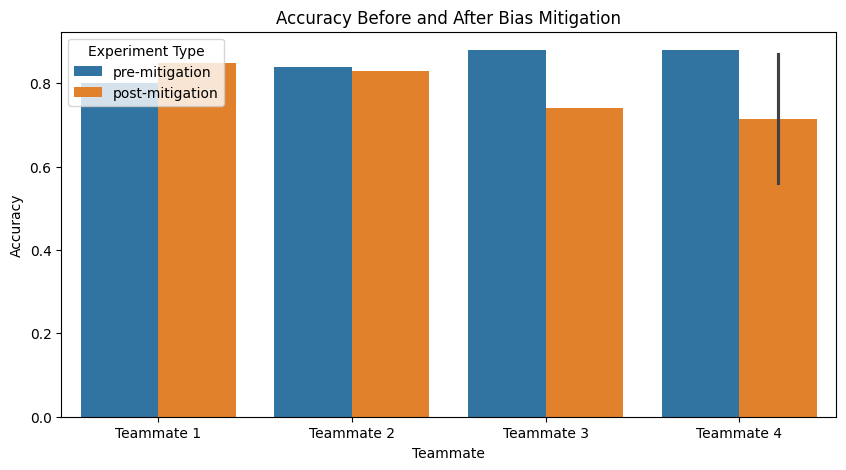

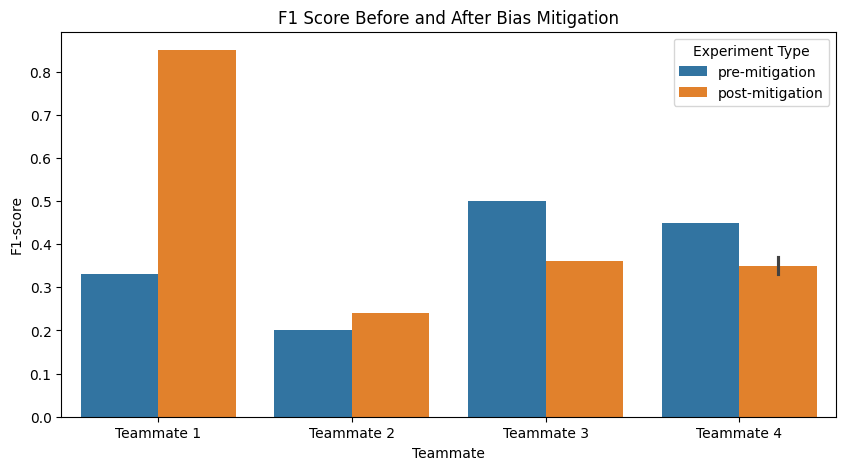

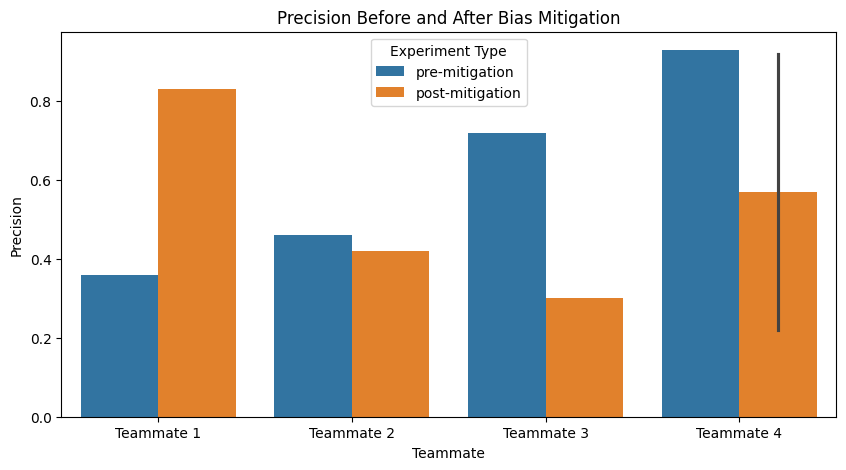

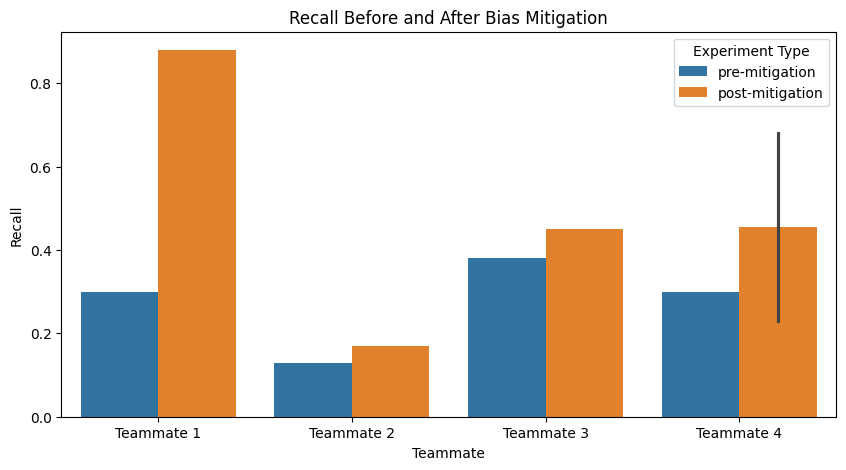

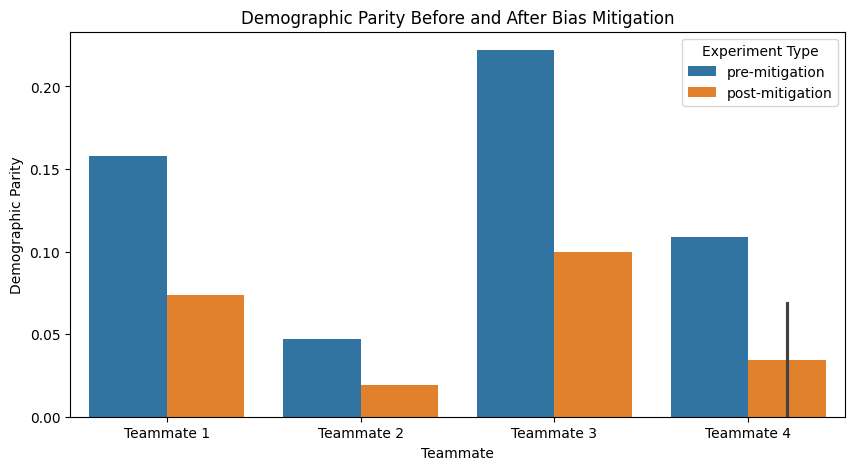

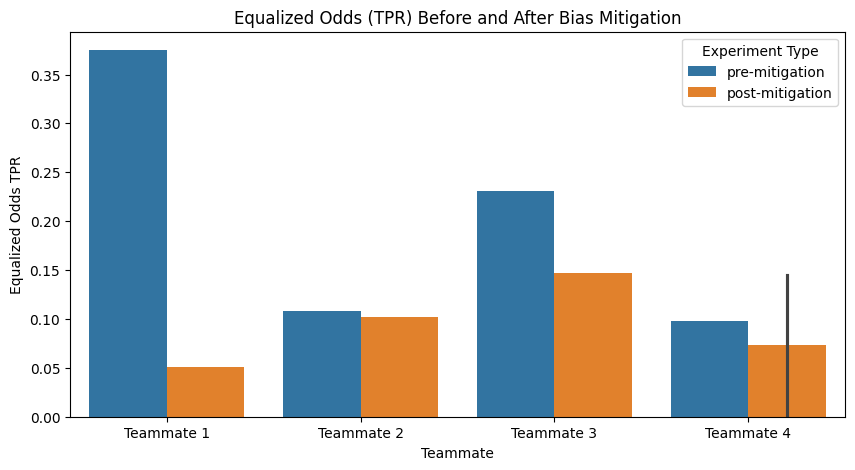

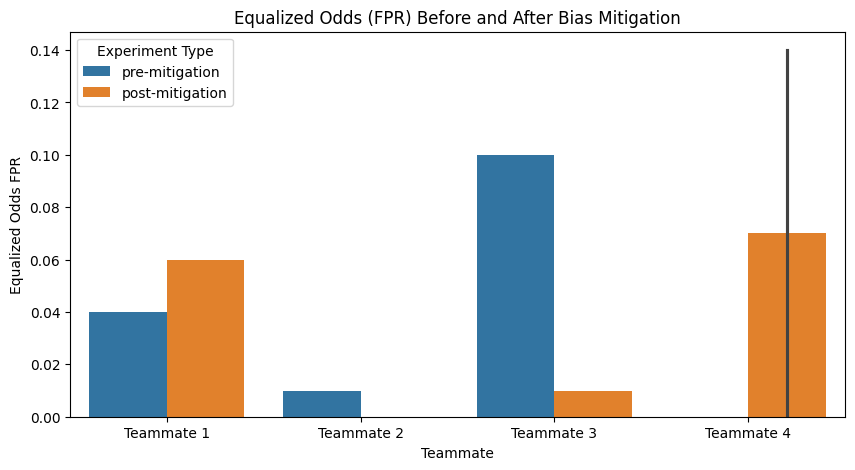

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert tuple values to separate columns for equalized odds

overall_results["equalized_odds_tpr"] = overall_results["equalized_odds"].apply(lambda x: x[0])
overall_results["equalized_odds_fpr"] = overall_results["equalized_odds"].apply(lambda x: x[1])
# overall_results.drop(columns=["equalized_odds"], inplace=True)

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="accuracy", hue="experiment_type")
plt.title("Accuracy Before and After Bias Mitigation")
plt.ylabel("Accuracy")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot F1 Score Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="f1_score", hue="experiment_type")
plt.title("F1 Score Before and After Bias Mitigation")
plt.ylabel("F1-score")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot Precision Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="precision", hue="experiment_type")
plt.title("Precision Before and After Bias Mitigation")
plt.ylabel("Precision")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot Recall Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="recall", hue="experiment_type")
plt.title("Recall Before and After Bias Mitigation")
plt.ylabel("Recall")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot Demographic Parity Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="demographic_parity", hue="experiment_type")
plt.title("Demographic Parity Before and After Bias Mitigation")
plt.ylabel("Demographic Parity")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot Equalized Odds Comparison (TPR)
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="equalized_odds_tpr", hue="experiment_type")
plt.title("Equalized Odds (TPR) Before and After Bias Mitigation")
plt.ylabel("Equalized Odds TPR")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# Plot Equalized Odds Comparison (FPR)
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x="teammate", y="equalized_odds_fpr", hue="experiment_type")
plt.title("Equalized Odds (FPR) Before and After Bias Mitigation")
plt.ylabel("Equalized Odds FPR")
plt.xlabel("Teammate")
plt.legend(title="Experiment Type")
plt.show()

# References

Teammate 1:
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html


Teammate 2:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html
- https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.preprocessing.Reweighing.html

Teammate 3:
- https://www.geeksforgeeks.org/k-nearest-neighbours/
- https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.inprocessing.AdversarialDebiasing.html
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html

Teammate 4:
- https://scikit-learn.org/stable/modules/svm.html
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html
- https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html
- https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html


General:
- https://scikit-learn.org/stable/api/sklearn.metrics.html
- https://fairlearn.org/main/user_guide/assessment/common_fairness_metrics.html
- https://fairlearn.org/main/user_guide/fairness_in_machine_learning.html



# Disclosures

[Disclose use of generative AI and similar tools here.]

We used generative AI tools to assist in finding library declarations, troubleshooting errors, and paraphrasing conclusions to improve clarity and conciseness.